In [31]:
# univariate multi-step lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from pandas import DataFrame


# import pandas as pd

from sklearn.model_selection import train_test_split
from keras import Model, layers
from keras.models import load_model, model_from_json


In [32]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    # print(data)
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    # print(train)
    test = array(split(test, len(test)/7))


    # print(train)
    # print(test)
    return train, test

In [33]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [34]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))


In [35]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)


In [36]:
# train the model
def build_and_train_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


In [37]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [38]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_and_train_model(train, n_input)
    model.save('models/RNN_UniVariate_BasicLSTM_Model_21dayinput.h5')

    # architecture to JSON, weights to HDF5
    model.save_weights('models/RNN_UniVariate_BasicLSTM_Model_Weights_21dayinput.h5')
    with open('models/RNN_UniVariate_BasicLSTM_Model_architecture_21dayinput.json', 'w') as f:
            f.write(model.to_json())
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [39]:
def load_pretrained_model(train, test, n_input):
    # architecture and weights from HDF5
    model = load_model('models/RNN_UniVariate_BasicLSTM_Model_21dayinput.h5')

    # architecture from JSON, weights from HDF5
    with open('models/RNN_UniVariate_BasicLSTM_Model_architecture_21dayinput.json') as f:
        model = model_from_json(f.read())
    model.load_weights('models/RNN_UniVariate_BasicLSTM_Model_Weights_21dayinput.h5')
    
    
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
    

In [40]:
# # print(data)
# y = df.Global_active_power
# X = df.drop('Global_active_power', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

# print("\nX_train:\n")
# print(X_train.head())
# print(X_train.shape)

# print("\nX_test:\n")
# print(X_test.head())
# print(X_test.shape)

In [41]:
# normalize
def normalize():
    df = DataFrame(read_csv('smart meter dataset\household_power_consumption\household_power_consumption_Naive_Forecast_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime']))
    df_z_scaled = df.copy()

    # apply normalization techniques
    for column in df_z_scaled.columns:
        df_z_scaled[column] = (df_z_scaled[column] -
                            df_z_scaled[column].mean()) / df_z_scaled[column].std()    

    # view normalized data   
    return (df_z_scaled)

In [43]:
# load the new file
dataset = read_csv('smart meter dataset\household_power_consumption\household_power_consumption_Naive_Forecast_days.csv', header=0, infer_datetime_format=True,)
# split into train and test
print(dataset.values)
train, test = split_dataset(dataset.values)
# # evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

[['2006-12-16' 1209.1759994328022 34.92199999466539 ... 546.0 4926.0
  14680.933325290682]
 ['2006-12-17' 3390.460001885891 226.00600032508373 ... 4187.0 13341.0
  36946.66670298576]
 ['2006-12-18' 2203.8259995877743 161.7920002900064 ... 2621.0 14018.0
  19028.43331074715]
 ...
 ['2010-11-24' 1796.2480028569696 132.460000410676 ... 2848.0 12224.0
  13769.466663122175]
 ['2010-11-25' 1431.1640011668203 116.12800028920174 ... 426.0 5072.0
  17278.733336210247]
 ['2010-11-26' 1488.1040012091396 120.82600023224951 ... 385.0 9989.0
  13347.73334145546]]
Epoch 1/70


UnimplementedError:  Cast string to float is not supported
	 [[node sequential_1/Cast (defined at \Temp/ipykernel_5864/3837563502.py:16) ]] [Op:__inference_train_function_3843]

Function call stack:
train_function


lstm: [0.636] 0.7, 0.7, 0.6, 0.6, 0.7, 0.5, 0.7


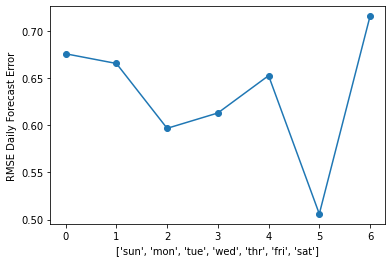

In [13]:
# evaluate model and get scores
n_input = 7
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

Epoch 1/70
69/69 [==============================] - 1s 5ms/step - loss: 1.1157
Epoch 2/70
69/69 [==============================] - 0s 5ms/step - loss: 0.9774
Epoch 3/70
69/69 [==============================] - 0s 5ms/step - loss: 0.7507
Epoch 4/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6918
Epoch 5/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6859
Epoch 6/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6840
Epoch 7/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6712
Epoch 8/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6726
Epoch 9/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6652
Epoch 10/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6683
Epoch 11/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6645
Epoch 12/70
69/69 [==============================] - 0s 5ms/step - loss: 0.6554
Epoch 13/70
69/69 [==============================

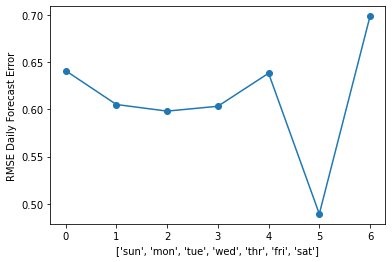

In [14]:
# load pretrained model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

lstm: [0.613] 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7


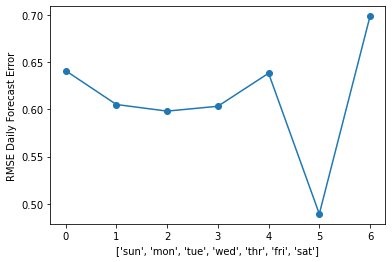

In [15]:
# load pretrained model and get scores
n_input = 14
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

Epoch 1/70
68/68 [==============================] - 1s 7ms/step - loss: 1.1360
Epoch 2/70
68/68 [==============================] - 1s 7ms/step - loss: 1.0228
Epoch 3/70
68/68 [==============================] - 1s 8ms/step - loss: 0.7875
Epoch 4/70
68/68 [==============================] - 1s 8ms/step - loss: 0.6976
Epoch 5/70
68/68 [==============================] - 1s 8ms/step - loss: 0.6692
Epoch 6/70
68/68 [==============================] - 1s 8ms/step - loss: 0.6643
Epoch 7/70
68/68 [==============================] - 1s 8ms/step - loss: 0.6780
Epoch 8/70
68/68 [==============================] - 1s 8ms/step - loss: 0.6643
Epoch 9/70
68/68 [==============================] - 1s 7ms/step - loss: 0.6525
Epoch 10/70
68/68 [==============================] - 1s 8ms/step - loss: 0.6501
Epoch 11/70
68/68 [==============================] - 1s 8ms/step - loss: 0.6417
Epoch 12/70
68/68 [==============================] - 1s 8ms/step - loss: 0.6582
Epoch 13/70
68/68 [==============================

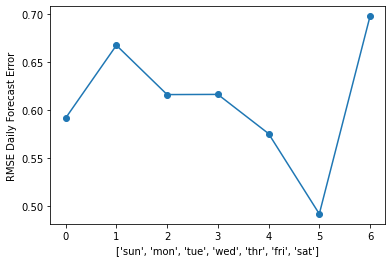

In [16]:
# load pretrained model and get scores
n_input = 21
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

lstm: [0.611] 0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.7


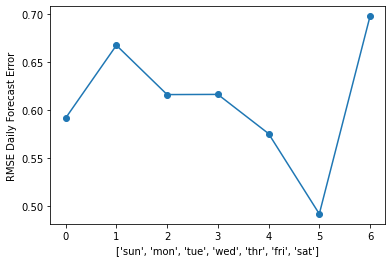

In [17]:
# load pretrained model and get scores
n_input = 21
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()